# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio, AssetEvaluator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
file_k200 = 'kospi200_prices_240710.csv'
file_etf = 'etfs_all_240710.csv'
download = False

## KOSPI200

In [4]:
k200 = DataManager(
    file = file_k200,
    universe = 'KOSPI200',
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [5]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if download else None

In [6]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [7]:
etf = DataManager(
    file = file_etf,
    universe = 'ETF',
    path = path_data
)
etf.upload()

870 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [8]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if download else None

In [9]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

# Backtest

## KOSPI 200

In [10]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [11]:
lags = dict(lookback=12, lag=5)

In [12]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [13]:
select = 'Momentum'
kwargs_build = dict(
    name=f'KOSPI:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [14]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'KOSPI:{select}', select =select,
))
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, KOSPI:Momentum, KOSPI:K-ratio


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:59<00:00, 19.70s/it]

Returning stats


,KOSPI:Momentum,KOSPI:K-ratio,KODEX200
start,2021-01-03,2021-01-03,2021-01-03
end,2024-07-10,2024-07-10,2024-07-10
cagr,0.728994,0.308676,0.020773
monthly_vol,0.467373,0.253572,0.174975
monthly_sharpe,1.399333,1.192595,0.204963
max_drawdown,-0.262851,-0.211644,-0.278222
avg_drawdown,-0.059227,-0.030276,-0.061003
avg_drawdown_days,17.488372,18.261905,180.0


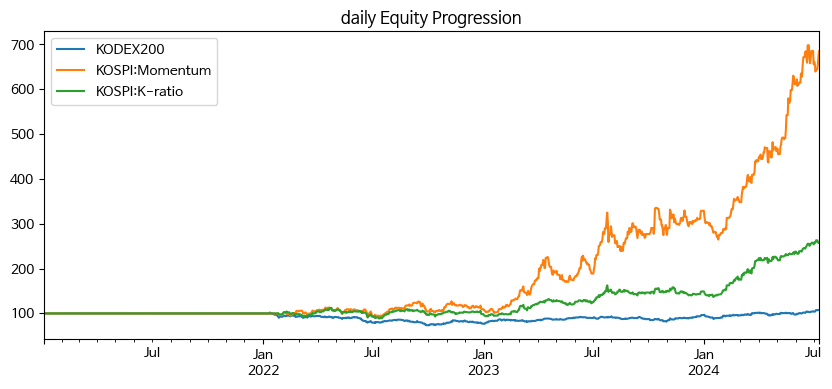

In [15]:
bm.run(figsize=(10,4), metrics=metrics2, stats_sort_by='monthly_sharpe')

In [16]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','KOSPI:Momentum']]
df_pf.head()

,KODEX200,KOSPI:Momentum
2021-01-03,100.0,100.0
2021-01-04,100.0,100.0
2021-01-05,100.0,100.0
2021-01-06,100.0,100.0
2021-01-07,100.0,100.0


## ETF

In [17]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year


In [18]:
lags = dict(lookback=12, lag=5)

In [19]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [20]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='ETF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='ETF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='ETF:InvVol', weigh='InvVol', **kwargs_build)

Backtesting 4 strategies: KODEX200, ETF:Eqaully, ETF:ERC, ETF:InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Returning stats


,ETF:Eqaully,ETF:ERC,ETF:InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,0.261244,0.214048,0.190885,0.341347
cagr,0.094482,0.078365,0.070315,0.121013
calmar,2.570011,2.036211,1.863784,0.960111
max_drawdown,-0.036763,-0.038486,-0.037727,-0.126041
avg_drawdown,-0.007851,-0.007471,-0.00685,-0.025636
avg_drawdown_days,12.771429,17.346154,17.461538,19.68
daily_vol,0.046101,0.040422,0.038887,0.125812
daily_sharpe,2.030856,1.93376,1.810946,0.993648


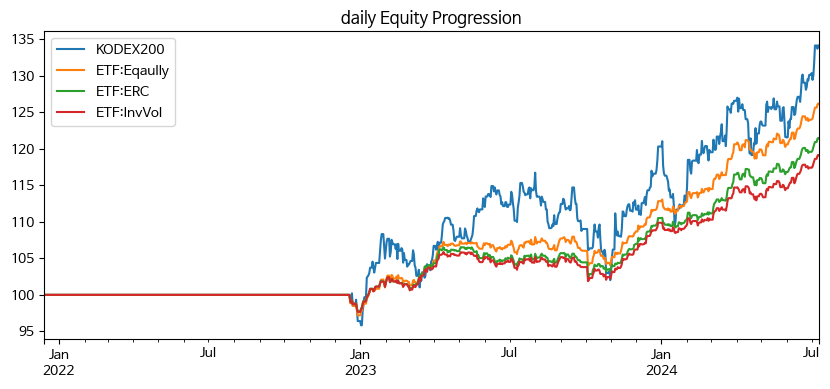

In [21]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [22]:
df = bm.get_historical()
df_pf = df_pf.join(df[['ETF:Eqaully', 'ETF:ERC']])

## Summary

### testing

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import FinanceDataReader as fdr
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import os, time, re, sys
from datetime import datetime, timedelta
from contextlib import contextmanager

from os import listdir
from os.path import isfile, join, splitext

import bt
from pf_custom import AlgoSelectKRatio, AlgoRunAfter, calc_kratio

import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

# support korean lang
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'

metrics = [
    'total_return', 'cagr', 'calmar', 
    'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 
    'daily_vol', 'daily_sharpe', 'daily_sortino', 
    'monthly_vol', 'monthly_sharpe', 'monthly_sortino'
]

WEEKS_IN_YEAR = 51


def import_rate1(file, path='.', cols=['date', None]):
    """
    file: historical of cumulative rate of return in long format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}', parse_dates=[0], index_col=[0])
    if df_rate.columns.size > 1:
        print('WARNING: taking the 1st two columns only.')
    # make sure to get series
    df_rate = df_rate.iloc[:, 0]
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate


def import_rate2(file, path='.', cols=['date', None], n_headers=1):
    """
    file: historical of cumulative rate of return in wide format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}')
    df_rate = df_rate.T.iloc[n_headers:, 0]

    df_rate.index = pd.to_datetime(df_rate.index)
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate
    

def get_price(df_rate, data_check, rate_is_percent=True):
    """
    calc price from rate of return
    """
    # date check
    for dt, _ in data_check:
        try:
            dt = pd.to_datetime(dt)
            rate = df_rate.loc[dt]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
    
    # convert to price with data_check[0]
    dt, price = data_check[0]
    dt = pd.to_datetime(dt)
    rate = df_rate.loc[dt]
    if rate_is_percent:
        rate = rate/100
        df_rate = df_rate/100
    price_base = price / (rate+1)
    df_price = (df_rate + 1) * price_base 

    # check price
    dt, price = data_check[1]
    e = df_price.loc[dt]/price - 1
    print(f'error: {e*100:.2f} %')
    
    return df_price


def convert_rate_to_price(data, n_headers=1, path=None, 
                          rate_is_percent=True, df_rate=None, rate_only=False):
    """
    data: series or dict
    df_rate: historical given as dataframe
    """
    data_type = data['data_type']
    if data_type == 1:
        import_rate = import_rate1
    elif data_type == 2:
        import_rate = lambda *args, **kwargs: import_rate2(*args, n_headers=n_headers, **kwargs)
    else:
        if df_rate is None:
            return print(f'ERROR: no data type {data_type} exists')
        else:
            import_rate = lambda *args, **kwargs: df_rate.rename_axis(kwargs['cols'][0]).rename(kwargs['cols'][1])
    
    ticker = data['ticker']
    name = data['name']
    file = f'{data['file']}.csv'
    data_check = [
        (data['check1_date'], data['check1_price']),
        (data['check2_date'], data['check2_price']),
    ]
    
    df = import_rate(file, path=path, cols=['date', ticker])
    if rate_only:
       return df
        
    df = get_price(df, data_check, rate_is_percent=rate_is_percent)
    if df is None:
        return print(f'ERROR: check {ticker}')
    else:
        return df


def get_date_range(dfs, symbol_name=None, return_intersection=False):
    """
    get datetime range of each ticker (columns) or datetime index of intersection
    dfs: index date, columns tickers
    symbol_name: dict of symbols to names
    """
    df = dfs.apply(lambda x: x[x.notna()].index.min()).to_frame('start date')
    df = df.join(dfs.apply(lambda x: x[x.notna()].index.max()).to_frame('end date'))
    if symbol_name is not None:
        df = pd.Series(symbol_name).to_frame('name').join(df)

    if return_intersection:
        start_date = df.iloc[:, 0].max()
        end_date = df.iloc[:, 1].min()
        return dfs.loc[start_date:end_date]
    else:
        return df.sort_values('start date')


def valuate_bond(face, rate, year, ytm, n_pay=1):
    """
    face: face value
    rate: coupon rate (annual)
    year: years to maturity
    ytm: discount rate (annual)
    n_pay: number of payments per year
    """
    c = face * rate / n_pay
    vc = 0
    r_discount = ytm/n_pay
    # calc The present value of expected cash flows
    for t in range(1, year*n_pay+1):
        vc += c/(1+r_discount)**t
    # the present value of the face value of the bond added
    return vc + face/(1+r_discount)**(year*n_pay)


def check_days_in_year(df, days_in_year=252, freq='M', n_thr=10):
    """
    freq: unit to check days_in_year in df
    """
    if freq == 'Y':
        grp_format = '%Y'
        #days_in_freq = days_in_year
        factor = 1
    elif freq == 'W':
        grp_format = '%Y%m%U'
        #days_in_freq = round(days_in_year/12/WEEKS_IN_YEAR)
        factor = 12 * WEEKS_IN_YEAR
    else: # default month
        grp_format = '%Y%m'
        #days_in_freq = round(days_in_year/12)
        factor = 12

    # calc mean days for each asset
    df_days = (df.assign(gb=df.index.strftime(grp_format)).set_index('gb')
                 .apply(lambda x: x.dropna().groupby('gb').count()[1:-1])
                 .mul(factor).mean().round())

    cond = (df_days != days_in_year)
    if cond.sum() > 0:
        df = df_days.loc[cond]
        n = len(df)
        if n < n_thr:
            #print(f'WARNING: the number of days in a year with followings is not {days_in_year} in setting:')
            print(f'WARNING: the number of days in a year with followings is {df.mean()} in avg.:')
            _ = [print(f'{k}: {int(v)}') for k,v in df.to_dict().items()]
        else:
            p = n / len(df_days) * 100
            #print(f'WARNING: the number of days in a year with {n} assets ({p:.0f}%) is not {days_in_year} in setting:')
            print(f'WARNING: the number of days in a year with {n} assets ({p:.0f}%) is {df.mean()} in avg.')
    
    return df_days


def align_period(df_assets, axis=0, date_format='%Y-%m-%d',
                 fill_na=True, print_msg1=True, print_msg2=True, n_indent=2):
    """
    axis: Determines the operation for handling missing data.
        0 : Drop rows (time index) with missing prices.
        1 : Drop columns (assets) with a count of non-missing prices less than the maximum found.
    fill_na: set False to drop nan fields
    """
    msg1 = None
    if axis == 0:
        df_aligned = get_date_range(df_assets, return_intersection=True)
        if len(df_aligned) < len(df_assets):
            dts = [x.strftime(date_format) for x in (df_aligned.index.min(), df_aligned.index.max())]
            msg1 = f"period reset: {' ~ '.join(dts)}"
    elif axis == 1:
        c_all = df_assets.columns
        df_cnt = df_assets.apply(lambda x: x.dropna().count())
        cond = (df_cnt < df_cnt.max())
        c_drop = c_all[cond]
        df_aligned = df_assets[c_all.difference(c_drop)]
        n_c = len(c_drop)
        if n_c > 0:
            n_all = len(c_all)
            msg1 = f'{n_c} assets removed for shorter periods ({n_c/n_all*100:.1f}%)'
    else:
        pass

    if print_msg1:
        print(msg1) if msg1 is not None else None
        if print_msg2:
            stats = df_aligned.isna().sum().div(df_aligned.count())
            t = 'filled forward' if fill_na else 'dropped'
            print(f'ratio of nan {t}::')
            indent = ' '*n_indent
            _ = [print(f'{indent}{i}: {stats[i]:.3f}') for i in stats.index]

    if fill_na:
        return df_aligned.ffill()
    else:
        return df_aligned.dropna()


def print_runtime(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time of {func.__name__}: {end_time - start_time:.2f} secs")
        return result
    return wrapper


def get_file_list(file, path='.'):
    """
    find files starting with str file
    """
    name, ext = splitext(file)
    name = name.replace('*', r'(.*?)')
    try:
        flist = [f for f in listdir(path) if isfile(join(path, f)) and re.search(name, f)]
    except Exception as e:
        print(f'ERROR: {e}')
        flist = []
    return sorted(flist)


class AssetDict(dict):
    """
    A dictionary subclass that associates keys (ex:asset tickers) with names.
    Attributes:
        names (dict): Optional dictionary mapping tickers to names.
    """
    def __init__(self, *args, names=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.names = names

    def __repr__(self):
        output = ""
        for i, key in enumerate(self.keys()):
            name = self.get_name(key)
            if name is None:
                output += f"{i}) {key}\n"
            else:
                output += f"{i}) {key}: {name}\n"
        return output

    def get_name(self, key):
        if self.names is None:
            return None
        else:
            try:
                return self.names[key]
            except KeyError:
                return None


class IndentOutput:
    def __init__(self, indent=4):
        self.indent = ' ' * indent
        self.old_target = sys.stdout
    
    def write(self, text):
        if text.strip():  # Only indent non-empty lines
            indented_text = f"{self.indent}{text.replace('\n', f'\n{self.indent}')}"
            self.old_target.write(indented_text)
        else:
            self.old_target.write(text)
    
    def flush(self):
        pass  # This method is needed to match the interface of sys.stdout

    @contextmanager
    def indented_output(self):
        old_stdout = sys.stdout
        sys.stdout = self
        try:
            yield
        finally:
            sys.stdout = old_stdout

#### class

In [63]:
from ffn import calc_stats, calc_perf_stats


class AssetEvaluator():
    def __init__(self, df_prices, days_in_year=252, metrics=metrics):
        # df of assets (assets in columns) which of each might have its own periods.
        # the periods of all assets will be aligned in every calculation.
        df_prices = df_prices.to_frame() if isinstance(df_prices, pd.Series) else df_prices
        if df_prices.index.name is None:
            df_prices.index.name = 'date' # set index name to run check_days_in_year
        _ = check_days_in_year(df_prices, days_in_year, freq='M')
        
        self.df_prices = df_prices
        self.days_in_year = days_in_year
        self.metrics = metrics
        self.bayesian_data = None


    def get_stats(self, metrics=None, sort_by=None, align_period=True, idx_dt=['start', 'end']):
        metrics = self._check_var(metrics, self.metrics)
        df_prices = self.df_prices
        if align_period:
            df_stats = calc_stats(df_prices).stats
        else:
            #df_stats = df_prices.apply(lambda x: calc_stats(x.dropna()).stats)
            df_stats = df_prices.apply(lambda x: calc_perf_stats(x.dropna()).stats)

        if (metrics is not None) and (metrics != 'all'):
            metrics = idx_dt + metrics
            df_stats = df_stats.loc[metrics]

        for i in df_stats.index:
            if i in idx_dt:
                df_stats.loc[i] = df_stats.loc[i].apply(lambda x: x.strftime('%Y-%m-%d'))

        if sort_by is not None:
            try:
                df_stats = df_stats.sort_values(sort_by, axis=1, ascending=False)
            except KeyError as e:
                print(f'WARNING: no sorting as {e}')

        return df_stats


    def get_freq_days(self, freq='daily'):
        if freq == 'yearly':
            n = self.days_in_year
        elif freq == 'monthly':
            n = round(self.days_in_year/12)
        elif freq == 'weekly':
            n = round(self.days_in_year/WEEKS_IN_YEAR)
        else: # default daily
            n = 1
            freq = 'daily'
        return (n, freq)

        
    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg


    def _calc_mean_return(self, df_prices, periods, days_in_year, annualize=True):
        scale = (days_in_year/periods) if annualize else 1
        return df_prices.apply(lambda x: x.pct_change(periods).dropna().mean() * scale)
        

    def _calc_volatility(self, df_prices, periods, days_in_year, annualize=True):
        scale = (days_in_year/periods) ** .5 if annualize else 1
        return df_prices.apply(lambda x: x.pct_change(periods).dropna().std() * scale)
        

    def _calc_sharpe(self, df_prices, periods, days_in_year, annualize=True, rf=0):
        mean = self._calc_mean_return(df_prices, periods, 0, False)
        std = self._calc_volatility(df_prices, periods, 0, False)
        scale = (days_in_year/periods) ** .5 if annualize else 1
        return (mean - rf) / std * scale


    def get_ref_val(self, freq='yearly', annualize=True, rf=0, align_period=False):
        """
        get ref val for 
        """
        df_prices = self.df_prices
        if align_period:
            df_prices = self.align_period(df_prices, axis=0, fill_na=True)
        days_in_year = self.days_in_year
        periods, freq = self.get_freq_days(freq)
        args = [df_prices, periods, days_in_year, annualize]
        return {
            f'{freq}_mean': self._calc_mean_return(*args).to_dict(),
            f'{freq}_vol': self._calc_volatility(*args).to_dict(),
            f'{freq}_sharpe': self._calc_sharpe(*args).to_dict()
        }


    def bayesian_sample(self, freq='yearly', annualize=True, rf=0, align_period=False,
                        sample_draws=1000, sample_tune=1000, target_accept=0.9,
                        multiplier_std=1000, 
                        rate_nu = 29, normality_sharpe=True, debug_annualize=False):
        """
        normality_sharpe: set to True if 
         -. You are making comparisons to Sharpe ratios calculated under the assumption of normality.
         -. You want to account for the higher variability due to the heavy tails of the t-distribution.
        """
        days_in_year = self.days_in_year
        periods, freq = self.get_freq_days(freq)
        factor_year = days_in_year/periods if annualize else 1

        df_prices = self.df_prices
        assets = list(df_prices.columns)
        
        if align_period:
            df_prices = self.align_period(df_prices, axis=0, fill_na=True)
            df_ret = df_prices.pct_change(periods).dropna() * factor_year
            mean_prior = df_ret.mean()
            std_prior = df_ret.std()
            std_low = std_prior / multiplier_std
            std_high = std_prior * multiplier_std
        else:
            ret_list = [df_prices[x].pct_change(periods).dropna() * factor_year for x in assets]
            mean_prior = [x.mean() for x in ret_list]
            std_prior = [x.std() for x in ret_list]
            std_low = [x / multiplier_std for x in std_prior]
            std_high = [x * multiplier_std for x in std_prior]
            returns = dict()
        
        num_assets = len(assets) # flag for comparisson of two assets
        coords={'asset': assets}

        with pm.Model(coords=coords) as model:
            # nu: degree of freedom (normality parameter)
            nu = pm.Exponential('nu_minus_two', 1 / rate_nu, testval=4) + 2.
            mean = pm.Normal('mean', mu=mean_prior, sigma=std_prior, dims='asset')
            std = pm.Uniform('vol', lower=std_low, upper=std_high, dims='asset')
            
            if align_period:
                returns = pm.StudentT(f'{freq}_returns', nu=nu, mu=mean, sigma=std, observed=df_ret)
            else:
                func = lambda x: dict(mu=mean[x], sigma=std[x], observed=ret_list[x])
                returns = {i: pm.StudentT(f'{freq}_returns[{x}]', nu=nu, **func(i)) for i, x in enumerate(assets)}

            fy2 = 1 if debug_annualize else factor_year
            pm.Deterministic(f'{freq}_mean', mean * fy2, dims='asset')
            pm.Deterministic(f'{freq}_vol', std * (fy2 ** .5), dims='asset')
            std_sr = std * pt.sqrt(nu / (nu - 2)) if normality_sharpe else std
            sharpe = pm.Deterministic(f'{freq}_sharpe', ((mean-rf) / std_sr) * (fy2 ** .5), dims='asset')
            
            if num_assets == 2:
                #mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
                #pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)
                sharpe_diff = pm.Deterministic('sharpe diff', sharpe[0] - sharpe[1])
    
            trace = pm.sample(draws=sample_draws, tune=sample_tune,
                              #chains=chains, cores=cores,
                              target_accept=target_accept,
                              #return_inferencedata=False, # TODO: what's for?
                              progressbar=True)
            
        self.bayesian_data = {'trace':trace, 'coords':coords, 'align_period':align_period,
                              'freq':freq, 'annualize':annualize, 'rf':rf}
        return None
        
    
    def bayesian_summary(self, var_names=None, filter_vars='like', **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            return az.summary(trace, var_names=var_names, filter_vars=filter_vars, **kwargs)


    def bayesian_plot(self, var_names=None, filter_vars='like', ref_val=None, **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            coords = self.bayesian_data['coords']
            freq = self.bayesian_data['freq']
            annualize = self.bayesian_data['annualize']
            rf = self.bayesian_data['rf']
            align_period = self.bayesian_data['align_period']

        if ref_val is None:
            ref_val = self.get_ref_val(freq=freq, annualize=annualize, rf=rf, align_period=align_period)
            col_name = list(coords.keys())[0]
            ref_val = {k: [{col_name:at, 'ref_val':rv} for at, rv in v.items()] for k,v in ref_val.items()}
        ref_val.update({'mean diff': [{'ref_val': 0}], 'sharpe diff': [{'ref_val': 0}]})

        _ = az.plot_posterior(trace, var_names=var_names, filter_vars=filter_vars,
                              ref_val=ref_val, **kwargs)
        #return ref_val
        return None


    def plot_trace(self, var_names=None, filter_vars='like', legend=False, figsize=(12,6), **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            return az.plot_trace(trace, var_names=var_names, filter_vars=filter_vars, 
                                 legend=legend, figsize=figsize, **kwargs)


    def plot_energy(self, **kwargs):
        if self.bayesian_data is None:
            return print('ERROR: run bayesian_sample first')
        else:
            trace = self.bayesian_data['trace']
            return az.plot_energy(trace, **kwargs)


    def align_period(self, df, axis=0, fill_na=True, **kwargs):
        return align_period(df, axis=axis, fill_na=fill_na, **kwargs)


In [23]:
ae = AssetEvaluator(df_pf, 245)

KODEX200: 246
KOSPI:Momentum: 246


In [24]:
ae.get_stats(sort_by='monthly_sharpe', align_period=True)

,KOSPI:Momentum,ETF:Eqaully,ETF:ERC,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,5.853925,0.261244,0.214048,0.074952
cagr,1.114276,0.094482,0.078365,0.028513
calmar,4.239199,2.570011,2.036211,0.102482
max_drawdown,-0.262851,-0.036763,-0.038486,-0.278222
avg_drawdown,-0.059227,-0.007851,-0.007471,-0.061003
avg_drawdown_days,17.488372,12.771429,17.346154,180.0
daily_vol,0.457045,0.046101,0.040422,0.17093
daily_sharpe,1.907894,2.030856,1.93376,0.253898


In [70]:
df_pf.dropna()

,KODEX200,KOSPI:Momentum,ETF:Eqaully,ETF:ERC
date,,,,
2021-12-14,100.0000,100.00000,100.00000,100.00000
2021-12-15,100.0000,100.00000,100.00000,100.00000
2021-12-16,100.0000,100.00000,100.00000,100.00000
2021-12-17,100.0000,100.00000,100.00000,100.00000
2021-12-20,100.0000,100.00000,100.00000,100.00000
...,...,...,...,...
2024-07-04,105.5647,639.64547,125.12004,120.60741
2024-07-05,107.5087,644.51747,125.64884,120.94276
2024-07-08,107.1577,656.24447,126.05834,121.37506


# Transaction

## KOSPI200

In [14]:
kwargs = dict(
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-02-29 loaded.


In [15]:
kwargs = dict(
    #date = '2024-01-01',
    #date = '2024-03-01',
    date = None,
    save = True
)
pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-07-05 to 2024-07-05
Weights of assets determined by ERC.
Net profit: 7,151,800
All transactions saved to pf_k200_momentum_240710.csv


name   price  transaction  net weights
date       asset                                                
2023-12-28 001570           금양  109200           14   14    0.16
           002710        TCC스틸   58800           31   31    0.19
           005070       코스모신소재  147300           15   15    0.22
           022100        포스코DX   74200           22   22    0.17
           042700        한미반도체   61700           43   43    0.27
2024-02-29 001570           금양   96500          -14    0    0.00
           002710        TCC스틸   67700           -9   22    0.15
           005070       코스모신소재  177100          -15    0    0.00
           006110        삼아알미늄   98900           17   17    0.17
           022100        포스코DX   54100            5   27    0.15
           042700        한미반도체   84800          -18   25    0.21
           267260     HD현대일렉트릭  124400           25   25    0.32
2024-07-10 000150           두산  233500            8    8    0.20
           001570           금양   82500            0    0    0.00
           002710        TCC스틸   49800          -22    0    0.00
           003230         삼양식품  619000            3    3    0.20
           005070       코스모신소재  148300            0    0    0.00
           006110        삼아알미늄   71000          -17    0    0.00
           010120  LS ELECTRIC  224500            8    8    0.20
           022100        포스코DX   37200          -27    0    0.00
           042700        한미반도체  162400          -13   12    0.21
           267260     HD현대일렉트릭  342000          -20    5    0.19

## ETF

In [12]:
kwargs = dict(
    file='pf_etf_static_240710.csv',
    method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=245,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-07-10 loaded.


In [13]:
pf_etf.transaction_pipeline(save=False)

6 assets from 2023-07-05 to 2024-07-05 prepared for weight analysis
Weights of assets determined by ERC.
ERROR: check the date as no new transaction
Set save=True to save transaction record


price  transaction  net  weights
date       asset                                    
2024-07-10 069500   39735           21   21     0.08
           148070  114330           16   16     0.18
           273130  112380           24   24     0.27
           284430   13490          118  118     0.16
           379800   17560           88   88     0.16
           411060   15005           93   93     0.14